#### Methodology to address fundamental problem 1 itemized in Issue 1024 - follow-up compare tabulations and relative household burden. This time I extend the 12-112 notebook to look at the revised methodology only.

### Indicator reviewed: 

Socioeconomic Factors Indicator reviewed
*  [Extreme Housing Burden](#housingburden)

#### Packages

In [10]:
import math
import numpy as np
import os
import pandas as pd
import requests
import zipfile
from pathlib import Path
import shutil

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### ETL process for acquiring relevant tables

#### NOTE: If you ran the ETL Process to acquire Table 8 in the other notebook of this draft PR you do not need to run the ETL cell block again

In [11]:
# Copy and adapt certain sections of code from data_pipeline.utils 

def download_hud_dataset():
    DOWNLOAD_FILENAME = "HUD_ZIPPED.csv"
    HOUSING_FTP_URL = "https://www.huduser.gov/portal/datasets/cp/2014thru2018-140-csv.zip"    
    response = requests.get(HOUSING_FTP_URL, verify=True)
    if response.status_code == 200:
        file_contents = response.content
    else:
        sys.exit(
            f"HTTP response {response.status_code} from url {file_url}. Info: {response.content}"
        )

    # Write the contents to disk.
    file = open(DOWNLOAD_FILENAME, "wb")
    file.write(file_contents)
    file.close()
    
def extract_zipped_download(zip_file_path, unzipped_path):
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        zip_ref.extractall(unzipped_path)
    # cleanup temporary file
    os.remove(zip_file_path)
    
def up_one_directory(path):
    try:
        # from Python 3.6
        parent_dir = Path(path).parents[1]
        # for Python 3.4/3.5, use str to convert the path to string
        # parent_dir = str(Path(path).parents[1])
        shutil.move(path, parent_dir)
    except IndexError:
        # no upper directory
        pass

CURRENT_DIRECTORY = os.getcwd()
download_hud_dataset()
extract_zipped_download(CURRENT_DIRECTORY + "/HUD_ZIPPED.csv", CURRENT_DIRECTORY)  
up_one_directory(CURRENT_DIRECTORY + "/140/Table8.csv")
shutil.rmtree("./140/")

### Extreme Housing Burden <a id='housingburden'></a>

The Extreme Housing Burden indicator represents the proportion of low-income households that have to spend more than half their income on rent. These households experience higher levels of stress, report lower health, and may delay medical treatment because of its high cost.

The Extreme Housing Burden indicator measures the percent of households in a census tract that are:

1. Making less than 80% of the Area Median Family Income as determined by the Department of Housing and Urban Development (HUD), and
2. Paying greater than 50% of their income to housing costs. 

This data is sourced from the 2014-2018 Comprehensive Housing Affordability Strategy dataset from the Department of Housing and Urban Development (HUD) using the census tract geographic summary level, and contains cost burdens for households by percent HUD-adjusted median family income (HAMFI) category. This data can be found [here](https://www.huduser.gov/portal/datasets/cp.html). 

Because CHAS data is based on American Communities Survey (ACS) estimates, which come from a sample of the population, they may be unreliable if based on a small sample or population size.

The standard error and relative standard error were used to evaluate the reliability of each estimate using CalEnviroScreen’s methodology. 

Census tract estimates that met either of the following criteria were considered reliable and included in the analysis [(CalEnviroScreen, 2017, page 129)](https://oehha.ca.gov/media/downloads/calenviroscreen/report/ces3report.pdf ):

- Relative standard error less than 50 (meaning the standard error was less than half of the estimate), OR 
- Standard error less than the mean standard error of all census tract estimates 

Formulas for calculating the standard error of sums, proportions, and ratio come from the [American Communities Survey Office](https://www2.census.gov/programs-surveys/acs/tech_docs/accuracy/MultiyearACSAccuracyofData2013.pdf).

Note that this code creates a score and rank by state, for every state.

The relevant variables in table 8 of the CHAS dataset are the following (CHAS data dictionary available [here](https://www.huduser.gov/portal/datasets/cp/CHAS-data-dictionary-14-18.xlsx)):

|   Name  |                          Label                      |
|---------|-----------------------------------------------------|
|T1_est1  |                                   Total Occupied housing units                                      | 
|T8_est10 |            Owner occupied less than or equal to 30% of HAMFI cost burden greater than 50%           |
|T8_est23 |Owner occupied greater than 30% but less than or equal to 50% of HAMFI	cost burden greater than 50%|
|T8_est36 |Owner occupied	greater than 50% but less than or equal to 80% of HAMFI	cost burden greater than 50%|
|T8_est76 |           Renter occupied less than or equal to 30% of HAMFI cost burden greater than 50%           |
|T8_est89 |Renter occupied	greater than 30% but less than or equal to 50% of HAMFI	cost burden greater than 50%|
|T8_est102|Renter occupied	greater than 50% but less than or equal to 80% of HAMFI	cost burden greater than 50%|
 

### Below I also propose an alternate means for ranking census tracts
### These steps are outlined and commented below

In [12]:
# Read in the data from https://www.huduser.gov/portal/datasets/cp.html
housing = pd.read_csv("Table8.csv", 
                      encoding = "ISO-8859-1",  
                      dtype = {'Tract_ID': object, 'st': object, 'geoid': object})

# Remove data for states that aren't included in the census (e.g. American Samoa, Guam, etc.):
housing.drop(housing.loc[housing['st'] == '72'].index, inplace = True)

# Combine owner and renter occupied low-income households that make less than 80% of HAMFI into one variable
housing['summed'] = (housing['T8_est10'] + 
                     housing['T8_est23'] + 
                     housing['T8_est36'] + 
                     housing['T8_est76'] + 
                     housing['T8_est89'] + 
                     housing['T8_est102'])

# Create a variable for the standard error of the summed variables
housing['summed_se'] = np.sqrt((housing['T8_moe10'] / 1.645)**2 + 
                                (housing['T8_moe23'] / 1.645)**2 + 
                                (housing['T8_moe36'] / 1.645)**2 + 
                                (housing['T8_moe76'] / 1.645)**2 + 
                                (housing['T8_moe89'] / 1.645)**2 + 
                                (housing['T8_moe102'] / 1.645)**2)

# Remove the first 7 digits in the FIPS Census Tract ID 
housing['geoid'] = housing['geoid'].str[-11:]

# Find the estimate of the proportion of the population that is heavily rent burdened
housing['hbrd_score'] = housing['summed'] / housing['T8_est1']

# Change rates where the population is 0 to nan
housing['hbrd_score'].replace(np.inf, np.nan, inplace = True)

# Create function for calculating the standard error, using the proportions standard error formula
#  if the value under the radical is negative, use the ratio standard error formula
def se_prop(x, y, se_x, moe_y): 
    se_y = moe_y / 1.645
    test = se_x**2 - (((x**2)/(y**2))*((se_y)**2))
    se = np.where(test < 0,
                   (1/y) * np.sqrt(se_x**2 + (((x**2)/(y**2))*(se_y**2))), 
                   (1/y) * np.sqrt(se_x**2 - (((x**2)/(y**2))*(se_y**2))))
    return se

housing['se'] = se_prop(housing['summed'], housing['T8_est1'], housing['summed_se'], housing['T8_moe1'])

# Calculate the relative standard error
housing['rse'] = housing['se'] / housing['hbrd_score']*100

# Change infinite rse's where the housing burden is 0 to np.nan
housing['rse'].replace(np.inf, np.nan, inplace = True)

# Calculate the mean standard error for each state
housing['mean_state_se'] = np.zeros(len(housing))

for state in housing['st'].unique():
    mean_se = np.mean(housing[housing['st'] == state]['se'])
    housing['mean_state_se'].loc[housing['st'] == state] = mean_se
    
# Find census tract estimates that meet both of the following criteria and are thus considered unreliable estimates: 
# RSE less than 50 AND
# SE less than the mean state SE or housing burdened low income households
# Convert these scores to nan
housing.loc[(housing['rse'] >= 50) & (housing['rse'] >= housing['mean_state_se']), 'hbrd_score'] = np.nan

# Rename columns
housing = housing.rename(columns = {'geoid' :'FIPS_tract_id',
                                    'st' : 'state'
                                   })

# Calculate percentile rank for census tracts with a score above 0, set percentile to 0 if score is 0, for each state
housing['hbrd_rank'] = housing[
            housing['hbrd_score'] != 0][['hbrd_score',
                'state']].groupby('state').rank( 
                na_option = 'keep', 
                pct = True) * 100

housing.loc[housing['hbrd_score'] == 0, 'hbrd_rank'] = 0

# Create final housing burden df
housingburden = housing.copy()

/Users/sarahluw/justice-40-main/justice40-tool/data/data-pipeline/justifce-40-main-env/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sarahluw/justice-40-main/justice40-tool/data/data-pipeline/justifce-40-main-env/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [13]:
housingburden.head()

,source,sumlevel,FIPS_tract_id,name,state,cnty,tract,T8_est1,T8_est2,T8_est3,...,T8_moe131,T8_moe132,T8_moe133,summed,summed_se,hbrd_score,se,rse,mean_state_se,hbrd_rank
0,2014thru2018,140,01001020100,"Census Tract 201, Autauga County, Alabama",01,1,20100,765,570,50,...,12,12,12,80,31.721807,0.104575,0.041032,39.237314,0.036604,46.298077
1,2014thru2018,140,01001020200,"Census Tract 202, Autauga County, Alabama",01,1,20200,720,465,65,...,12,12,12,138,45.531874,0.191667,0.061614,32.146659,0.036604,83.269231
2,2014thru2018,140,01001020300,"Census Tract 203, Autauga County, Alabama",01,1,20300,1295,840,60,...,12,12,12,170,53.722921,0.131274,0.040927,31.176999,0.036604,63.653846
3,2014thru2018,140,01001020400,"Census Tract 204, Autauga County, Alabama",01,1,20400,1640,1260,15,...,12,12,12,145,46.288510,0.088415,0.027822,31.467397,0.036604,34.615385
4,2014thru2018,140,01001020500,"Census Tract 205, Autauga County, Alabama",01,1,20500,4175,2320,175,...,17,17,17,595,147.221693,0.142515,0.034760,24.390193,0.036604,68.221154


In [14]:
housingburden.shape

(73056, 280)

### As desired we see a uniform distribution for the percentile rank for burdened households

<AxesSubplot:title={'center':'Relative Housing Burden (Percentile rank) - CalEnvironScreen Methodology'}, xlabel='Percentile Rank', ylabel='Relative Frequency in Support'>

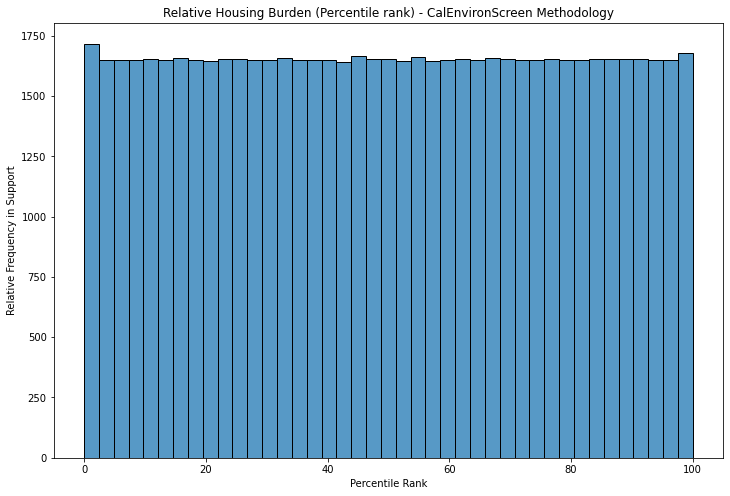

In [15]:
plt.figure(figsize=(12, 8))
plt.title('Relative Housing Burden (Percentile rank) - CalEnvironScreen Methodology')
# Set x-axis label
plt.xlabel('Percentile Rank')
# Set y-axis label
plt.ylabel('Relative Frequency in Support')

sns.histplot(housingburden["hbrd_rank"])

### Now we compute for a baseline comparison 

In [16]:
# Owner occupied numerator fields
OWNER_OCCUPIED_NUMERATOR_FIELDS = [
    # Column Name
    #   Line_Type
    #   Tenure
    #   Household income
    #   Cost burden
    #   Facilities
    "T8_est7",
    #   Subtotal
    #   Owner occupied
    #   less than or equal to 30% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est10",
    #   Subtotal
    #   Owner occupied
    #   less than or equal to 30% of HAMFI
    #   greater than 50%
    #   All
    "T8_est20",
    
    #   Subtotal
    #   Owner occupied
    #   greater than 30% but less than or equal to 50% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est23",
    #   Subtotal
    #   Owner occupied
    #   greater than 30% but less than or equal to 50% of HAMFI
    #   greater than 50%
    #   All
    "T8_est33",
    #   Subtotal
    #   Owner occupied
    #   greater than 50% but less than or equal to 80% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est36",
    #   Subtotal
    #   Owner occupied
    #   greater than 50% but less than or equal to 80% of HAMFI
    #   greater than 50%
    #   All
]

# These rows have the values where HAMFI was not computed, b/c of no or negative income.
OWNER_OCCUPIED_NOT_COMPUTED_FIELDS = [
    # Column Name
    #   Line_Type
    #   Tenure
    #   Household income
    #   Cost burden
    #   Facilities
    "T8_est13",
    #   Subtotal
    #   Owner occupied
    #   less than or equal to 30% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est26",
    #   Subtotal
    #   Owner occupied
    #   greater than 30% but less than or equal to 50% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est39",
    #   Subtotal
    #   Owner occupied
    #   greater than 50% but less than or equal to 80% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est52",
    #   Subtotal
    #   Owner occupied
    #   greater than 80% but less than or equal to 100% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est65",
    #   Subtotal
    #   Owner occupied
    #   greater than 100% of HAMFI
    #   not computed (no/negative income)
    #   All
]

OWNER_OCCUPIED_POPULATION_FIELD = "T8_est2"
#   Subtotal
#   Owner occupied
#   All
#   All
#   All

OWNER_OCCUPIED_POPULATION_HAMFI_FIELD = "T8_est3"
#   Subtotal
#   Owner occupied 
#   All
#   All
#   All

# Renter occupied numerator fields
RENTER_OCCUPIED_NUMERATOR_FIELDS = [
    # Column Name
    #   Line_Type
    #   Tenure
    #   Household income
    #   Cost burden
    #   Facilities
    "T8_est73",
    #   Subtotal
    #   Renter occupied
    #   less than or equal to 30% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est76",
    #   Subtotal
    #   Renter occupied
    #   less than or equal to 30% of HAMFI
    #   greater than 50%
    #   All
    "T8_est86",
    #   Subtotal
    #   Renter occupied
    #   greater than 30% but less than or equal to 50% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est89",
    #   Subtotal
    #   Renter occupied
    #   greater than 30% but less than or equal to 50% of HAMFI
    #   greater than 50%
    #   All
    "T8_est99",
    #   Subtotal
    #   Renter occupied	greater than 50% but less than or equal to 80% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est102",
    #   Subtotal
    #   Renter occupied
    #   greater than 50% but less than or equal to 80% of HAMFI
    #   greater than 50%
    #   All
]

# These rows have the values where HAMFI was not computed, b/c of no or negative income.
RENTER_OCCUPIED_NOT_COMPUTED_FIELDS = [
    # Column Name
    #   Line_Type
    #   Tenure
    #   Household income
    #   Cost burden
    #   Facilities
    "T8_est79",
    #   Subtotal
    #   Renter occupied	less than or equal to 30% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est92",
    #   Subtotal
    #   Renter occupied	greater than 30% but less than or equal to 50% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est105",
    #   Subtotal
    #   Renter occupied
    #   greater than 50% but less than or equal to 80% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est118",
    #   Subtotal
    #   Renter occupied	greater than 80% but less than or equal to 100% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est131",
    #   Subtotal
    #   Renter occupied
    #   greater than 100% of HAMFI
    #   not computed (no/negative income)
    #   All
]

# T8_est68	SubtotalRenter occupied	All	All	All
RENTER_OCCUPIED_POPULATION_FIELD = "T8_est68"

In [17]:
housingburden["current_summed_methodology"] = housingburden[
    OWNER_OCCUPIED_NUMERATOR_FIELDS
].sum(axis=1) + housingburden[RENTER_OCCUPIED_NUMERATOR_FIELDS].sum(axis=1)

In [18]:
housingburden["current_methodology_denominator"] = (
         housingburden[OWNER_OCCUPIED_POPULATION_FIELD]
            + housingburden[RENTER_OCCUPIED_POPULATION_FIELD]
            - housingburden[OWNER_OCCUPIED_NOT_COMPUTED_FIELDS].sum(axis=1)
            - housingburden[RENTER_OCCUPIED_NOT_COMPUTED_FIELDS].sum(axis=1)
)

In [19]:
housingburden["current_methodology_denominator_sans_not_computed"] = (
         housingburden[OWNER_OCCUPIED_POPULATION_FIELD]
            + housingburden[RENTER_OCCUPIED_POPULATION_FIELD]
)

In [20]:
housingburden["current_methodology_percent"] = np.round(
    (housingburden["current_summed_methodology"] / housingburden["current_methodology_denominator"] ), 2) * 100

In [21]:
housingburden["absolute_difference"] = housingburden[
    "current_summed_methodology"] - housingburden["summed"]

In [22]:
housingburden.to_csv("housing_burden_percentiles_12122021.csv", index=False)

### Now we construct the distribution of differences in the number of owned and rented burdened households


<AxesSubplot:title={'center':'Distribution of differences between two methodologies'}, xlabel='Aggregate total owner and renter occupied low-income households < 80%', ylabel='Relative Frequency in Support'>

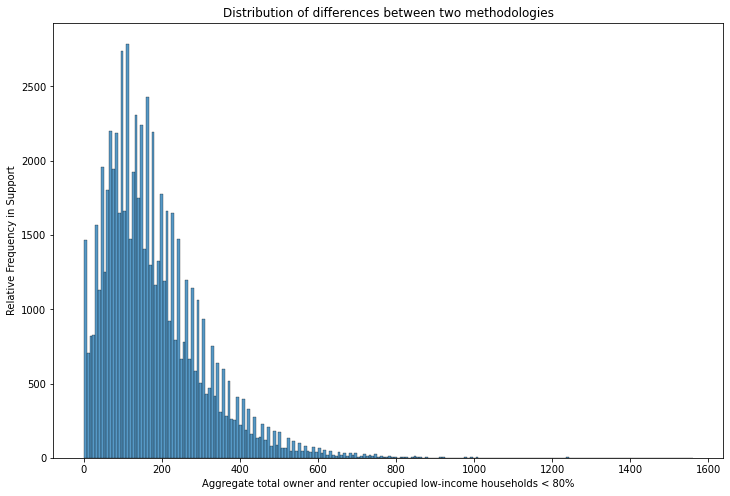

In [23]:

plt.figure(figsize=(12, 8))
plt.title('Distribution of differences between two methodologies')
# Set x-axis label
plt.xlabel('Aggregate total owner and renter occupied low-income households < 80%')
# Set y-axis label
plt.ylabel('Relative Frequency in Support')

sns.histplot(housingburden["absolute_difference"])

### Plotting both distributions for accounting for different aggregations of owned and rented burdened households. Red is the revised version; green is the current methodology

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2103

Text(0.5, 0, 'Aggregate total owner and renter occupied low-income households < 80%')

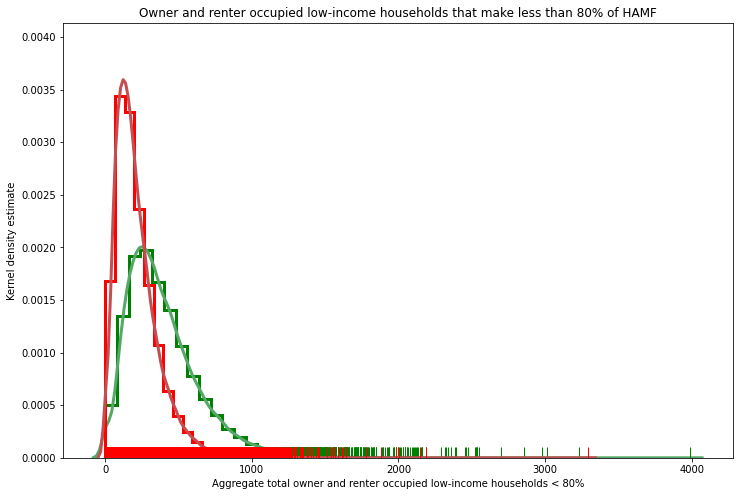

In [9]:
sns.set_color_codes()
plt.figure(figsize=(12, 8))
plt.title('Owner and renter occupied low-income households that make less than 80% of HAMF')
# Set y-axis label
plt.ylabel('Kernel density estimate')

sns.distplot(housingburden["current_summed_methodology"], 
      rug_kws={"color": "green"}, rug = True, 
          kde_kws={"color": "g", "lw": 3, "label": "KDE"},
          hist_kws={"histtype": "step", "linewidth": 3,
                    "alpha": 1, "color": "green"}
            )
sns.distplot(housingburden["summed"], 
          rug_kws={"color": "red"}, rug = True, 
          kde_kws={"color": "r", "lw": 3, "label": "KDE"},
          hist_kws={"histtype": "step", "linewidth": 3,
                    "alpha": 1, "color": "red"}
            )

plt.xlabel('Aggregate total owner and renter occupied low-income households < 80%')


## Now let's focus on West Virginia (FIPS code 54) and perform a nonparametric test to validate that the distributions are different for the health burden across all census tracts within West Virginia


Permutation sampling is a method to simulate the hypothesis that two variables have identical probability distributions. We perform this below. The red ECDF is the current tabulation of burdened household. The blue the proposed methodology for tabulation.

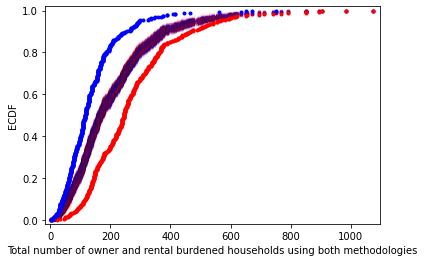

In [54]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y


current_methodology = housingburden[housingburden["state"] == '54']["current_summed_methodology"].values
revised_methodology = housingburden[housingburden["state"] == '54']["summed"].values

for _ in range(100):
    # Generate permutation samples
    perm_sample_1, perm_sample_2 = permutation_sample(current_methodology, revised_methodology)


    # Compute ECDFs
    x_1, y_1 = ecdf(perm_sample_1)
    x_2, y_2 = ecdf(perm_sample_2)

    # Plot ECDFs of permutation sample
    _ = plt.plot(x_1, y_1, marker='.', linestyle='none',
                 color='red', alpha=0.02)
    _ = plt.plot(x_2, y_2, marker='.', linestyle='none',
                 color='blue', alpha=0.02)

# Create and plot ECDFs from original data
x_1, y_1 = ecdf(current_methodology)
x_2, y_2 = ecdf(revised_methodology)
_ = plt.plot(x_1, y_1, marker='.', linestyle='none', color='red')
_ = plt.plot(x_2, y_2, marker='.', linestyle='none', color='blue')

# Label axes, set margin, and show plot
plt.margins(0.02)
_ = plt.xlabel('Total number of owner and rental burdened households using both methodologies')
_ = plt.ylabel('ECDF')
plt.show()

Notice that the permutation samples ECDFs overlap and give a purple haze. None of the ECDFs from the permutation samples overlap with the observed data, suggesting that the hypothesis is not commensurate with the data. Both methodologies for housing burden are not identically distributed.



## Nonparametric two-sample bootstrap test for sample mean

We now want to test the hypothesis that both methodologies have the same average housing burden across all census tracts in West Virginia, but not necessarily the same distribution, which is also impossible with a permutation test.

To do the two-sample bootstrap test, we shift both arrays to have the same mean, since we are simulating the hypothesis that their means are, in fact, equal. We then draw bootstrap samples out of the shifted arrays and compute the difference in means. This constitutes a bootstrap replicate, and we generate many of them. The p-value is the fraction of replicates with a difference in means greater than or equal to what was observed.

**Conclusion**:

We actually have evidence that the means are equal and corroborate a similar result as when we performed in the permutation test. Nonetheless, remember that it is important to carefully think about what question we want to ask. Are we only interested in the mean housing burden, or in the distribution of housing burdens across a state's census tract??

In [63]:
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of one dimensional data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""
    # Initialize array of replicates
    bs_replicates = np.empty(size)
    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)
    return bs_replicates

def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

# Compute difference of mean burden from data
empirical_diff_means = diff_of_means(current_methodology, revised_methodology)

# Compute mean of all burdens (population)
mean_burden = np.mean(np.append(current_methodology, revised_methodology))

# Generate shifted arrays
burden_a_shifted = current_methodology - np.mean(current_methodology) + mean_burden
burden_b_shifted = revised_methodology - np.mean(revised_methodology) + mean_burden

# Compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_a = draw_bs_reps(burden_a_shifted, np.mean, size=10000)
bs_replicates_b = draw_bs_reps(burden_b_shifted, np.mean, size=10000)

# Get replicates of difference of means
bs_replicates = bs_replicates_a - bs_replicates_b

# Compute and print p-value
p = np.sum(bs_replicates >= empirical_diff_means) / len(bs_replicates)
print("P Value: {:.4f}".format(round(p, 2)))

P Value: 0.0000


### Percentiles Comparison

In [24]:
final_df = housingburden[['FIPS_tract_id', 'state','hbrd_rank','hbrd_score', 'summed', 
       'current_summed_methodology', 'T8_est1', 
        "current_methodology_denominator_sans_not_computed",
       'current_methodology_denominator',  'current_methodology_percent']]

##### First notice here that **T8_est1** and **current_methodology_denominator** should represent same or similar aggregates. In general, we cen see that the current computation performed results in a differerntial that undercounts the total occupied and rental households.

In [25]:
final_df["differences_aggregate_denominator"] = (
    final_df["current_methodology_denominator"] - final_df["T8_est1"] 
)

/Users/sarahluw/justice-40-main/justice40-tool/data/data-pipeline/justifce-40-main-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
final_df["differences_aggregate_denominator_sans_not_computed"] = (
    final_df["current_methodology_denominator"] - final_df["T8_est1"] 
)

/Users/sarahluw/justice-40-main/justice40-tool/data/data-pipeline/justifce-40-main-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:title={'center':'Distribution of differences between aggregate totals that normalizes tabulation of poverty households'}, xlabel='Aggregate differences in total owner and renter occupied low-income households < 80%', ylabel='Relative Frequency in Support'>

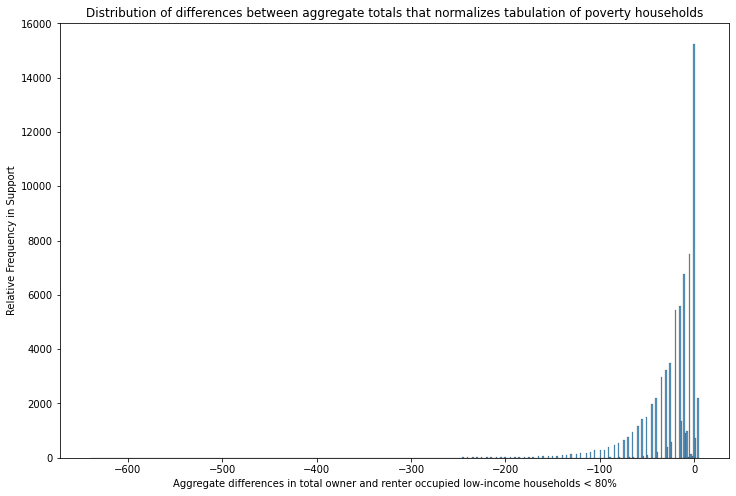

In [28]:
plt.figure(figsize=(12, 8))
plt.title('Distribution of differences between aggregate totals that normalizes tabulation of poverty households')
# Set x-axis label
plt.xlabel('Aggregate differences in total owner and renter occupied low-income households < 80%')
# Set y-axis label
plt.ylabel('Relative Frequency in Support')

sns.histplot(final_df["differences_aggregate_denominator"])

<AxesSubplot:title={'center':'Distribution of differences between aggregate totals that normalizes tabulation of poverty households (with removal of not computed fields) '}, xlabel='Aggregate differences in total owner and renter occupied low-income households', ylabel='Relative Frequency in Support'>

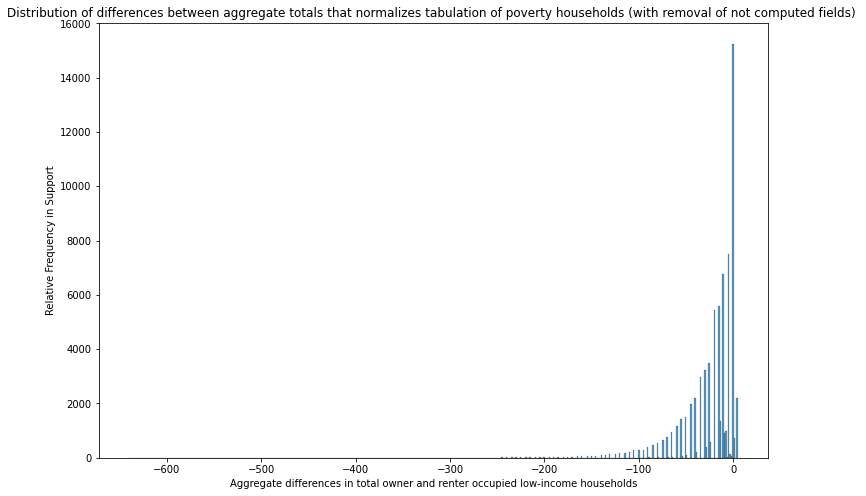

In [29]:
plt.figure(figsize=(12, 8))
plt.title('Distribution of differences between aggregate totals that normalizes tabulation of poverty households (with removal of not computed fields) ')
# Set x-axis label
plt.xlabel('Aggregate differences in total owner and renter occupied low-income households')
# Set y-axis label
plt.ylabel('Relative Frequency in Support')

sns.histplot(final_df["differences_aggregate_denominator_sans_not_computed"])

### Only include non-NA tracts for comparison purposes

In [30]:
final_df = final_df[~final_df["hbrd_rank"].isna()]

In [31]:
common_percentile = 90

# (final_df['current_methodology_percent'] >= 90).value_counts()

final_df["current_threshold_exceeded"] = (final_df['current_methodology_percent'] >= 90)

In [32]:
final_df["new_threshold_exceeded"] = (final_df['hbrd_rank'] >= 90)

In [33]:
final_df["new_threshold_exceeded"].value_counts()

False    61012
True      6801
Name: new_threshold_exceeded, dtype: int64

In [34]:
final_df["current_threshold_exceeded"].value_counts()

False    67811
True         2
Name: current_threshold_exceeded, dtype: int64

In [35]:
final_df["hbrd_rank"].sort_values(ascending=False)[:10]

20543    100.0
71328    100.0
22446    100.0
39484    100.0
61182    100.0
27460    100.0
59657    100.0
31732    100.0
12998    100.0
29681    100.0
Name: hbrd_rank, dtype: float64

In [36]:
# find the corresponding tracts that are different between the two
final_df.loc[final_df[
    'current_threshold_exceeded'] != final_df['new_threshold_exceeded']].head()

,FIPS_tract_id,state,hbrd_rank,hbrd_score,summed,current_summed_methodology,T8_est1,current_methodology_denominator_sans_not_computed,current_methodology_denominator,current_methodology_percent,differences_aggregate_denominator,differences_aggregate_denominator_sans_not_computed,current_threshold_exceeded,new_threshold_exceeded
50,01005950700,01,92.019231,0.234146,144,218,615,615,607,36.0,-8,-8,False,True
66,01011952100,01,96.153846,0.269767,174,222,645,645,641,35.0,-4,-4,False,True
78,01015000200,01,91.346154,0.229839,285,475,1240,1245,1225,39.0,-15,-15,False,True
79,01015000300,01,91.057692,0.229508,280,488,1220,1215,1175,42.0,-45,-45,False,True
97,01015002101,01,99.519231,0.363184,365,483,1005,1000,970,50.0,-35,-35,False,True


In [43]:
final_df = final_df[final_df["new_threshold_exceeded"] == True]

In [37]:
# final_df.to_csv("housing_burdencomparison_two_methods_12192021.csv", index=False)

In [46]:
# california is number 1
# second is 
final_df.state.value_counts()[:10]

06    781
48    466
36    466
12    399
42    305
17    299
39    276
26    257
37    203
34    196
Name: state, dtype: int64

In [90]:
census_acs_2019 = pd.read_csv("../data/dataset/census_acs_2019/usa.csv")

In [91]:
census_acs_2019.dtypes

GEOID10_TRACT                                                             int64
Unemployed civilians (percent)                                          float64
Linguistic isolation (percent)                                          float64
Median household income in the past 12 months                             int64
Percent of individuals < 100% Federal Poverty Line                      float64
Percent of individuals < 150% Federal Poverty Line                      float64
Percent of individuals < 200% Federal Poverty Line                      float64
Median value ($) of owner-occupied housing units                          int64
Percent individuals age 25 or over with less than high school degree    float64
Percent enrollment in college or graduate school                        float64
Black or African American alone                                           int64
American Indian and Alaska Native alone                                   int64
Asian alone                             

In [92]:
census_acs_2019["GEOID10_TRACT"].head()

0    1073001100
1    1073001400
2    1073002000
3    1073003802
4    1073004000
Name: GEOID10_TRACT, dtype: int64

In [93]:
final_df['FIPS_tract_id'] = final_df['FIPS_tract_id'].astype(np.int64)

In [94]:
final_df.dtypes

FIPS_tract_id                                            int64
state                                                   object
hbrd_rank                                              float64
hbrd_score                                             float64
summed                                                   int64
current_summed_methodology                               int64
T8_est1                                                  int64
current_methodology_denominator_sans_not_computed        int64
current_methodology_denominator                          int64
current_methodology_percent                            float64
differences_aggregate_denominator                        int64
differences_aggregate_denominator_sans_not_computed      int64
current_threshold_exceeded                                bool
new_threshold_exceeded                                    bool
dtype: object

In [177]:
merge_1 = census_acs_2019.merge(final_df, 
                                left_on = "GEOID10_TRACT", 
                                right_on = "FIPS_tract_id")

In [178]:
merge_1.head()

,GEOID10_TRACT,Unemployed civilians (percent),Linguistic isolation (percent),Median household income in the past 12 months,Percent of individuals < 100% Federal Poverty Line,Percent of individuals < 150% Federal Poverty Line,Percent of individuals < 200% Federal Poverty Line,Median value ($) of owner-occupied housing units,Percent individuals age 25 or over with less than high school degree,Percent enrollment in college or graduate school,...,summed,current_summed_methodology,T8_est1,current_methodology_denominator_sans_not_computed,current_methodology_denominator,current_methodology_percent,differences_aggregate_denominator,differences_aggregate_denominator_sans_not_computed,current_threshold_exceeded,new_threshold_exceeded
0,1073002000,0.137549,0.019732,27159,0.513352,0.616172,0.727976,68400,0.233405,0.063934,...,360,620,1455,1455,1425,44.0,-30,-30,False,True
1,1073003802,0.103332,0.000000,38721,0.196560,0.340389,0.529012,64100,0.143187,0.083550,...,460,775,1925,1925,1885,41.0,-40,-40,False,True
2,1073004000,0.211483,0.044787,18525,0.405843,0.585077,0.707856,67300,0.170472,0.039753,...,375,665,1515,1515,1420,47.0,-95,-95,False,True
3,1073005101,0.092632,0.000000,15833,0.622069,0.833103,0.842069,51000,0.254545,0.090062,...,149,329,640,635,625,53.0,-15,-15,False,True
4,1073010302,0.152021,0.019872,20696,0.401938,0.511390,0.593873,71900,0.158696,0.063147,...,385,590,1510,1510,1410,42.0,-100,-100,False,True


In [317]:
cdc_places = pd.read_csv("../data/dataset/cdc_places//usa.csv")

In [318]:
cdc_le = pd.read_csv("../data/dataset/cdc_life_expectancy///usa.csv")

In [319]:
# all CDC datasets
temp_cdc = cdc_places.merge(cdc_le, on = "GEOID10_TRACT")

In [320]:
# Segregation
holc = pd.read_csv("../data/dataset/mapping_inequality/usa.csv")

In [334]:
# urban--rural
geo_corr = pd.read_csv("../data/dataset/geocorr/usa.csv")

In [336]:
geo_corr.head()

,GEOID10_TRACT,population_in_rural_areas,population_in_urban_areas,perc_population_in_rural_areas,perc_population_in_urban_areas,Urban Heuristic Flag
0,1001020100,318.0,1594.0,0.166318,0.833682,1
1,1001020200,NaN,2170.0,NaN,1.000000,1
2,1001020300,NaN,3373.0,NaN,1.000000,1
3,1001020400,NaN,4386.0,NaN,1.000000,1
4,1001020500,4.0,10762.0,0.000372,0.999628,1


In [337]:
merge_2 = temp_cdc.merge(holc, on="GEOID10_TRACT")

merge_3 = merge_2.merge(geo_corr, on="GEOID10_TRACT")

In [345]:
combined_df = merge_3.merge(merge_1, on="GEOID10_TRACT")

In [346]:
combined_df.head()

,GEOID10_TRACT,All teeth lost among adults aged >=65 years,Arthritis among adults aged >=18 years,Binge drinking among adults aged >=18 years,Cancer (excluding skin cancer) among adults aged >=18 years,Cervical cancer screening among adult women aged 21-65 years,Cholesterol screening among adults aged >=18 years,Chronic kidney disease among adults aged >=18 years,Chronic obstructive pulmonary disease among adults aged >=18 years,Coronary heart disease among adults aged >=18 years,...,summed,current_summed_methodology,T8_est1,current_methodology_denominator_sans_not_computed,current_methodology_denominator,current_methodology_percent,differences_aggregate_denominator,differences_aggregate_denominator_sans_not_computed,current_threshold_exceeded,new_threshold_exceeded
0,1073000700,42.3,36.7,9.7,6.0,82.6,88.9,6.2,13.6,10.6,...,304,494,1070,1070,1015,49.0,-55,-55,False,True
1,1073001500,33.5,34.7,11.4,5.8,84.9,88.4,5.3,11.7,9.5,...,290,540,1235,1235,1150,47.0,-85,-85,False,True
2,1073001600,32.0,37.4,10.5,7.0,85.8,90.1,5.6,12.2,10.1,...,230,365,970,970,970,38.0,0,0,False,True
3,1073001902,35.8,35.7,10.6,5.4,84.2,87.3,5.4,13.3,9.7,...,185,405,815,815,780,52.0,-35,-35,False,True
4,1073002000,31.7,37.2,10.6,6.1,84.8,88.4,5.3,13.6,9.5,...,360,620,1455,1455,1425,44.0,-30,-30,False,True


In [340]:
combined_df.columns

Index(['GEOID10_TRACT', 'All teeth lost among adults aged >=65 years',
       'Arthritis among adults aged >=18 years',
       'Binge drinking among adults aged >=18 years',
       'Cancer (excluding skin cancer) among adults aged >=18 years',
       'Cervical cancer screening among adult women aged 21-65 years',
       'Cholesterol screening among adults aged >=18 years',
       'Chronic kidney disease among adults aged >=18 years',
       'Chronic obstructive pulmonary disease among adults aged >=18 years',
       'Coronary heart disease among adults aged >=18 years',
       'Current asthma among adults aged >=18 years',
       'Current lack of health insurance among adults aged 18-64 years',
       'Current smoking among adults aged >=18 years',
       'Depression among adults aged >=18 years',
       'Diagnosed diabetes among adults aged >=18 years',
       'Fair or poor self-rated health status among adults aged >=18 years',
       'Fecal occult blood test, sigmoidoscopy, or colon

In [347]:
combined_df = combined_df[[
    'GEOID10_TRACT', 'state',
      'Life expectancy (years)', 
     'Unemployed civilians (percent)', 'Percent of individuals < 200% Federal Poverty Line',
       'Median value ($) of owner-occupied housing units',
       'Percent individuals age 25 or over with less than high school degree',
       'Percent enrollment in college or graduate school',
       'Black or African American alone',
       'American Indian and Alaska Native alone', 
       'Non-Hispanic White', 'Hispanic or Latino',
       'Percent Black or African American alone',
       'Percent American Indian and Alaska Native alone',
       'Percent Non-Hispanic White',
        'Linguistic isolation (percent)',
     'Percent of tract that is HOLC Grade D',
       'Current lack of health insurance among adults aged 18-64 years',                           
       'Median household income in the past 12 months',                           
       'Percent Hispanic or Latino', 'hbrd_rank', 'current_methodology_percent',
        'current_summed_methodology',
    "Urban Heuristic Flag"
]]

In [358]:
combined_df.columns

Index(['GEOID10_TRACT', 'state', 'Life expectancy (years)',
       'Unemployed civilians (percent)',
       'Percent of individuals < 200% Federal Poverty Line',
       'Median value ($) of owner-occupied housing units',
       'Percent individuals age 25 or over with less than high school degree',
       'Percent enrollment in college or graduate school',
       'Black or African American alone',
       'American Indian and Alaska Native alone', 'Non-Hispanic White',
       'Hispanic or Latino', 'Percent Black or African American alone',
       'Percent American Indian and Alaska Native alone',
       'Percent Non-Hispanic White', 'Linguistic isolation (percent)',
       'Percent of tract that is HOLC Grade D',
       'Current lack of health insurance among adults aged 18-64 years',
       'Median household income in the past 12 months',
       'Percent Hispanic or Latino', 'hbrd_rank',
       'current_methodology_percent', 'current_summed_methodology',
       'Urban Heuristic Flag', 

In [349]:
combined_df_percent_cols_df = combined_df[[ 'Unemployed civilians (percent)', 'Percent of individuals < 200% Federal Poverty Line',
       'Percent individuals age 25 or over with less than high school degree',
       'Percent enrollment in college or graduate school', 
        'Percent Black or African American alone',
       'Percent American Indian and Alaska Native alone',
       'Percent Non-Hispanic White',
       'Percent of tract that is HOLC Grade D',
        'Percent Hispanic or Latino',          
        'Linguistic isolation (percent)','hbrd_rank', 'current_methodology_percent',
       'Current lack of health insurance among adults aged 18-64 years']]

In [350]:
combined_df_percent_cols_df.head()

,Unemployed civilians (percent),Percent of individuals < 200% Federal Poverty Line,Percent individuals age 25 or over with less than high school degree,Percent enrollment in college or graduate school,Percent Black or African American alone,Percent American Indian and Alaska Native alone,Percent Non-Hispanic White,Percent of tract that is HOLC Grade D,Percent Hispanic or Latino,Linguistic isolation (percent),hbrd_rank,current_methodology_percent,Current lack of health insurance among adults aged 18-64 years
0,0.185822,0.749017,0.254487,0.026838,0.981511,0.000000,0.008261,0.412893,0.000000,0.000000,97.307692,49.0,28.4
1,0.138911,0.675538,0.256080,0.047828,0.941683,0.000000,0.045010,0.940744,0.011742,0.011864,92.115385,47.0,25.7
2,0.104283,0.505814,0.267835,0.041570,0.827300,0.000000,0.150448,0.457115,0.018931,0.010363,92.403846,38.0,24.1
3,0.110846,0.743824,0.225941,0.064667,0.746539,0.000532,0.061768,0.679955,0.170394,0.034739,90.192308,52.0,27.9
4,0.137549,0.727976,0.233405,0.063934,0.638235,0.000000,0.277451,0.177047,0.075000,0.019732,93.846154,44.0,25.4


In [351]:
# these are not converted into percent 0 - 100 scale
percent_cols = [x for x in combined_df_percent_cols_df.columns if 'Percent' in x or '(percent)' in x]

In [352]:
combined_df_percent_cols_df[
    percent_cols] = combined_df_percent_cols_df[
    percent_cols].apply(lambda x: x * 100)

/Users/sarahluw/justice-40-main/justice40-tool/data/data-pipeline/justifce-40-main-env/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [380]:
combined_df[
    percent_cols] = combined_df[
    percent_cols].apply(lambda x: x * 100)

<AxesSubplot:>

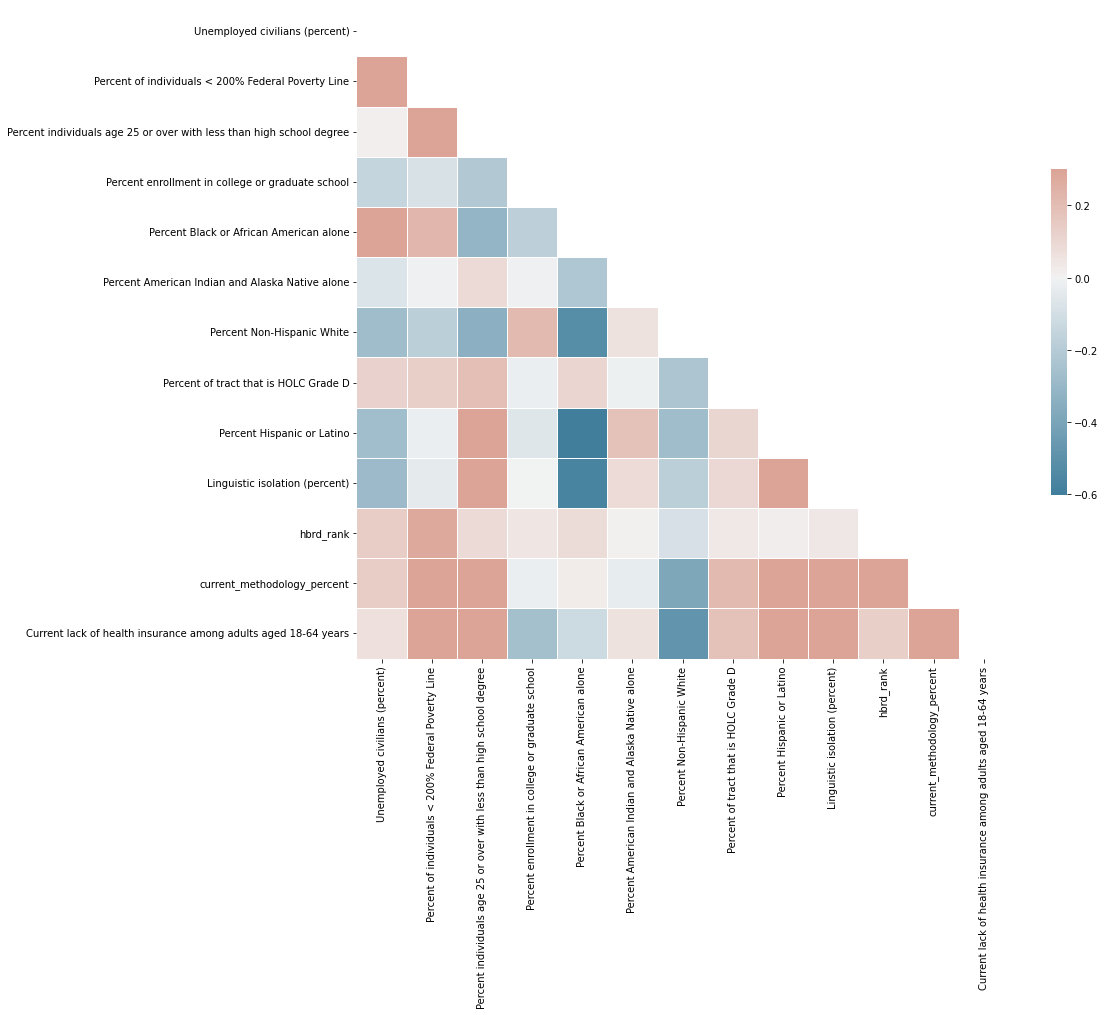

In [381]:
# Compute the correlation matrix
corr = combined_df_percent_cols_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### For the  CalEnvironScreen's Housing Burden Rank (CHBR) we identify some global trends across all of the tracts in this sample:
 1. poverty is most correlated with CHBR and current methodology (< 200 %)
 2. The current methodology is negativeley correlated with non-Hispanic white 
 3. CHBR is more "race-neutral" than current methodology in the sense that there is little to no relationship with racial identification across all states. However, if you look at it state by state, there is a clear pattern of stratification in Latin-X communities (see below for Califonia where the median of percentage of the tract that identifies as Latin-X is ~71%)
 4. CHBR is less positively correlated than the current current methodology as it pertains to high school education 

In [354]:
import us

In [382]:
mapping = us.states.mapping('fips', 'abbr')

In [383]:
for idx, row in combined_df.iterrows():
    current_row = str(combined_df.loc[idx, 'state'])
    state = mapping.get(current_row, None)
    combined_df.loc[idx, 'state_name'] = state

In [384]:
# CA', 'NY', 'TX', 'FL....33.8 % of sample
target_states = list(combined_df.state_name.value_counts()[:4].keys())

In [387]:
combined_df.groupby(["state_name", "Urban Heuristic Flag"]).agg({
       'GEOID10_TRACT': [np.median, 'nunique', np.std],
       'Percent of individuals < 200% Federal Poverty Line': [np.median, 'nunique', np.std],
       'Median value ($) of owner-occupied housing units': [np.median, 'nunique', np.std],
       'Percent individuals age 25 or over with less than high school degree': [np.median, 'nunique', np.std],
       'Percent enrollment in college or graduate school': [np.median, 'nunique', np.std],
       'Black or African American alone': [np.median, 'nunique', np.std],
       'American Indian and Alaska Native alone': [np.median, 'nunique', np.std],
#        'Hispanic or Latino': [np.median, 'nunique'. np.std],
       'Percent Black or African American alone': [np.median, 'nunique', np.std],
       'Percent American Indian and Alaska Native alone': [np.median, 'nunique', np.std],
       'Percent Non-Hispanic White': [np.median, 'nunique', np.std], 
        'Linguistic isolation (percent)': [np.median, 'nunique', np.std],
       'Percent of tract that is HOLC Grade D': [np.median, 'nunique', np.std],
       'Current lack of health insurance among adults aged 18-64 years': [np.median, 'nunique', np.std],
       'Median household income in the past 12 months': [np.median, 'nunique', np.std],
       'Percent Hispanic or Latino': [np.median, 'nunique', np.std],
      'hbrd_rank': [np.median, 'nunique', np.std],
      'current_methodology_percent': [np.median, 'nunique', np.std],
      'current_summed_methodology': [np.median, 'nunique', np.std, np.sum]

})

GEOID10_TRACT                        \
                                       median nunique           std   
state_name Urban Heuristic Flag                                       
AL         1                     1.073004e+09      32  1.300943e+07   
AR         1                     5.119003e+09       8  1.127022e+03   
AZ         1                     4.013114e+09       3  6.094271e+02   
CA         1                     6.037232e+09     203  1.731901e+07   
CO         1                     8.031002e+09      20  3.704786e+07   
CT         1                     9.009141e+09      26  3.293696e+06   
FL         1                     1.208600e+10      58  1.957837e+07   
GA         1                     1.312100e+10      52  7.432919e+07   
IA         1                     1.915300e+10      28  6.223814e+07   
IL         1                     1.703169e+10     140  5.016640e+07   
IN         1                     1.809735e+10      60  3.678425e+07   
KS         1                     2.017700e+10      26  1.806175e+07   
KY         1                     2.111100e+10      39  2.669390e+07   
LA         1                     2.207100e+10      40  1.816547e+07   
MA         1                     2.502508e+10      33  5.128717e+06   
MD         1                     2.451016e+10      24  5.696414e+04   
MI         1                     2.616351e+10      93  4.479618e+07   
MN         1                     2.710900e+10      50  3.595501e+07   
MO         1                     2.909502e+10      54  2.046098e+08   
MS         1                     2.804900e+10       6  3.702252e+03   
NC         1                     3.706700e+10      32  2.373815e+07   
NE         1                     3.105501e+10       9  2.699888e+07   
NH         1                     3.301100e+10      10  6.296447e+04   
NJ         1                     3.401301e+10      67  9.248087e+06   
NY         1                     3.604709e+10     191  3.047708e+07   
OH         1                     3.903514e+10     102  4.562677e+07   
OK         1                     4.010911e+10       9  1.786520e+07   
OR         1                     4.105100e+10       2  1.342796e+03   
PA         1                     4.210101e+10     114  3.646109e+07   
RI         1                     4.400702e+10       4  3.337164e+03   
SC         1                     4.507900e+10       3  1.000000e+02   
TN         1                     4.715700e+10      49  4.859379e+07   
TX         1                     4.827700e+10      26  1.436408e+08   
UT         1                     4.903510e+10      10  1.067454e+07   
VA         1                     5.171001e+10      51  1.365082e+08   
WA         1                     5.306300e+10      18  1.113819e+07   
WV         1                     5.402501e+10      10  2.002656e+07   

                                Percent of individuals < 200% Federal Poverty Line  \
                                                                            median   
state_name Urban Heuristic Flag                                                      
AL         1                                                             67.643799   
AR         1                                                             70.615485   
AZ         1                                                             80.139373   
CA         1                                                             59.575588   
CO         1                                                             57.204615   
CT         1                                                             56.974119   
FL         1                                                             65.491878   
GA         1                                                             65.496920   
IA         1                                                             50.998272   
IL         1                                                             61.578773   
IN         1                                                             

In [285]:
combined_df[
    percent_cols] = combined_df[
    percent_cols].apply(lambda x: x * 100)

In [286]:
combined_df.shape

(1702, 74)

In [287]:
# Remove college student-dominted tracts

In [388]:
combined_df = combined_df[~(combined_df['Percent enrollment in college or graduate school'] > 50)]

In [389]:
combined_df.shape

(1679, 25)

In [390]:
combined_df["GEOID10_TRACT"] = combined_df["GEOID10_TRACT"].astype(str)

In [397]:
# california only
combined_df_ca = combined_df[combined_df["state_name"].isin(target_states[:1])]

In [398]:
# combined_df_covriates_df = combined_df.select_dtypes(include=['float64'])

In [399]:
combined_df_ca = combined_df_ca[~(combined_df_temp[
    'Life expectancy (years)'].isna())]

In [400]:
combined_df_ca.columns

Index(['GEOID10_TRACT', 'state', 'Life expectancy (years)',
       'Unemployed civilians (percent)',
       'Percent of individuals < 200% Federal Poverty Line',
       'Median value ($) of owner-occupied housing units',
       'Percent individuals age 25 or over with less than high school degree',
       'Percent enrollment in college or graduate school',
       'Black or African American alone',
       'American Indian and Alaska Native alone', 'Non-Hispanic White',
       'Hispanic or Latino', 'Percent Black or African American alone',
       'Percent American Indian and Alaska Native alone',
       'Percent Non-Hispanic White', 'Linguistic isolation (percent)',
       'Percent of tract that is HOLC Grade D',
       'Current lack of health insurance among adults aged 18-64 years',
       'Median household income in the past 12 months',
       'Percent Hispanic or Latino', 'hbrd_rank',
       'current_methodology_percent', 'current_summed_methodology',
       'Urban Heuristic Flag', 

### California

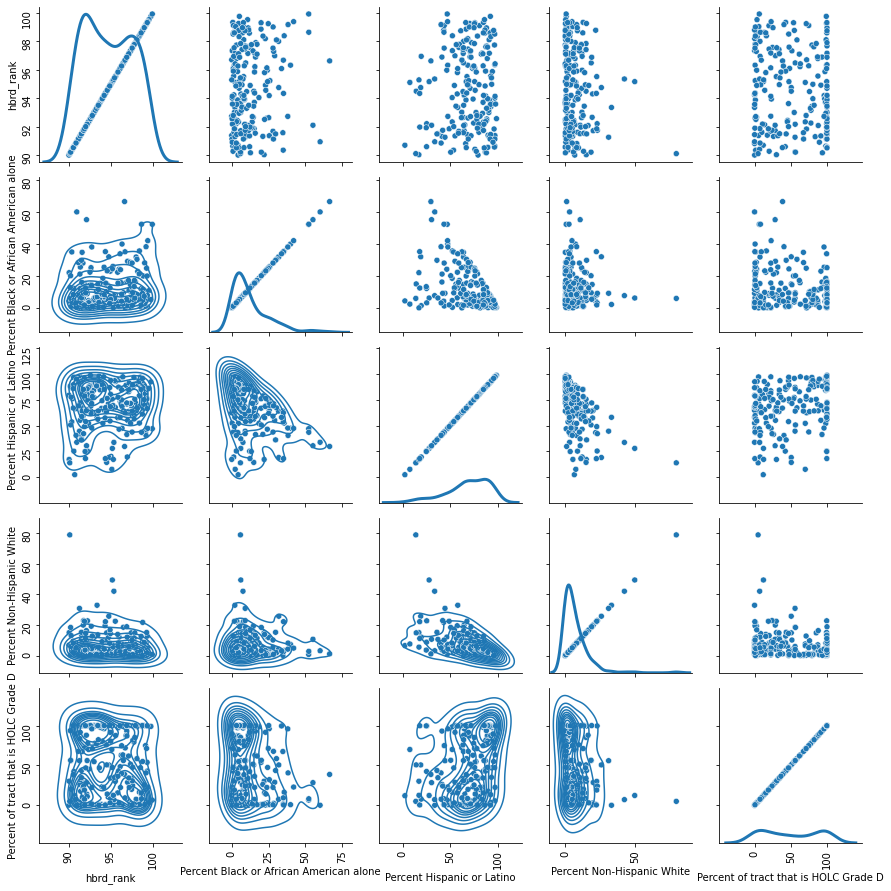

In [402]:
g = sns.PairGrid(combined_df_ca, vars=[
    'hbrd_rank',
    'Percent Black or African American alone',
    'Percent Hispanic or Latino',
    'Percent Non-Hispanic White', 
    'Percent of tract that is HOLC Grade D',
], hue="state_name")
g.map(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=True)
for ax in g.axes.flatten():
    ax.tick_params(rotation = 90)

In [403]:
# california
combined_df_ca.describe()[[  'Percent of tract that is HOLC Grade D', 'hbrd_rank',
    'Percent Black or African American alone',   'Percent Hispanic or Latino']]

,Percent of tract that is HOLC Grade D,hbrd_rank,Percent Black or African American alone,Percent Hispanic or Latino
count,200.000000,200.000000,200.000000,200.000000
mean,49.934217,94.704210,12.206068,69.108188
std,38.189406,2.851635,12.303871,21.819032
min,0.021211,90.015381,0.000000,2.271945
25%,11.743312,92.135029,3.400622,57.850864
50%,46.881043,94.488593,8.230863,71.470214
75%,93.231289,97.209049,16.030965,87.245156
max,100.000000,99.923097,66.404987,98.806510


In [299]:
# new york only
combined_df_temp_ny = combined_df[combined_df["state_name"].isin(target_states[1:2])]

In [404]:
# NY
combined_df_temp_ny.describe()[[  'Percent of tract that is HOLC Grade D', 'hbrd_rank',
    'Percent Black or African American alone',  'Percent Hispanic or Latino',]]

,Percent of tract that is HOLC Grade D,hbrd_rank,Percent Black or African American alone,Percent Hispanic or Latino
count,190.000000,190.000000,190.000000,190.000000
mean,58.844553,94.807277,39.024388,32.793867
std,38.073437,2.913433,29.728935,23.783760
min,0.000388,90.019317,0.000000,0.725013
25%,22.629137,92.187165,6.711240,13.048737
50%,63.812445,94.795020,39.553706,26.705685
75%,99.999996,97.290191,64.919144,53.726487
max,100.000011,99.914145,92.979298,88.705036


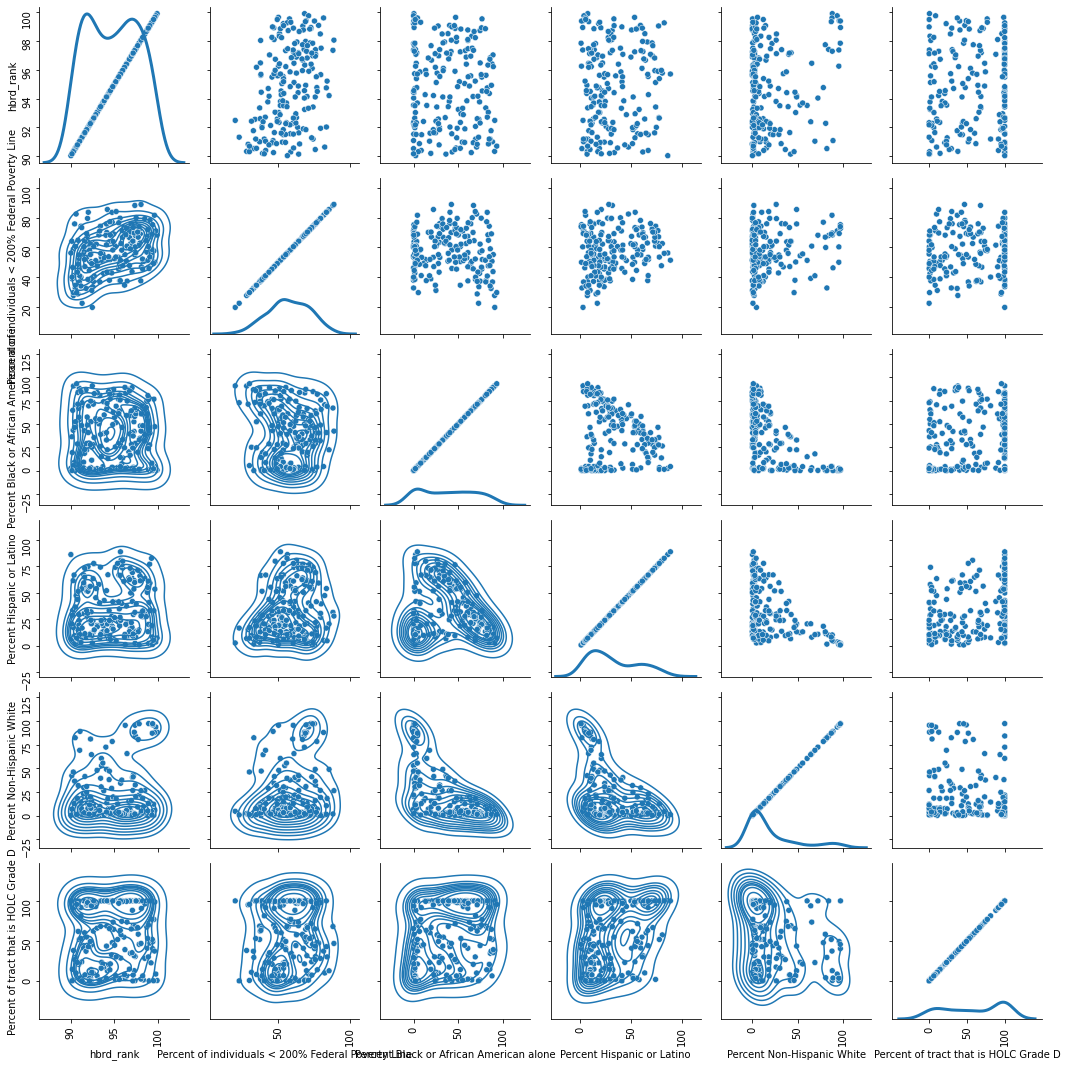

In [309]:
g = sns.PairGrid(combined_df_temp_ny, vars=[
    'hbrd_rank',
    'Percent of individuals < 200% Federal Poverty Line',
    'Percent Black or African American alone',
    'Percent Hispanic or Latino',
    'Percent Non-Hispanic White', 
 'Percent of tract that is HOLC Grade D',    
], hue="state_name")
g.map(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=True)
for ax in g.axes.flatten():
    ax.tick_params(rotation = 90)

In [405]:
# texas  only
combined_df_tx = combined_df[combined_df["state_name"].isin(target_states[2:3])]

In [ ]:
# NY
combined_df_temp_ny.describe()[[  'Percent of tract that is HOLC Grade D', 'hbrd_rank',
    'Percent Black or African American alone',  'Percent Hispanic or Latino',]]